
 ### **Task 3: SB3**
- Implement a **SB3** agent in the env of your choice


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

import highway_env  # noqa: F401


TRAIN = True

if __name__ == "__main__":
    n_cpu = 6
    batch_size = 64
    env = make_vec_env("racetrack-v0", n_envs=n_cpu)
    model = PPO(
        "MlpPolicy",
        env,
        policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
        n_steps=batch_size * 12 // n_cpu,
        batch_size=batch_size,
        n_epochs=10,
        learning_rate=5e-4,
        gamma=0.9,
        verbose=2,
        tensorboard_log="racetrack_ppo/",
    )
    # Train the model
    if TRAIN:
        model.learn(total_timesteps=int(1e5))
        model.save("racetrack_ppo/model")
        del model

    # Run the algorithm
    model = PPO.load("racetrack_ppo/model", env=env)


Using cuda device


c:\Users\tedma\miniconda3\envs\dl-env\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
c:\Users\tedma\miniconda3\envs\dl-env\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Logging to racetrack_ppo/PPO_1
----------------------------
| time/              |     |
|    fps             | 25  |
|    iterations      | 1   |
|    time_elapsed    | 29  |
|    total_timesteps | 768 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 61          |
|    total_timesteps      | 1536        |
| train/                  |             |
|    approx_kl            | 0.009921572 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.0143      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0219     |
|    std                  | 0.952       |
|    value_loss           | 0.118       |
----------

ValueError: ('Render mode is None, which is incompatible with RecordVideo.', 'Initialize your environment with a render_mode that returns an image, such as rgb_array.')

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt
import highway_env
import numpy as np
import tensorboard
from stable_baselines3 import DQN

from configs.config_sb3 import config_dict as config_dict_sdb3


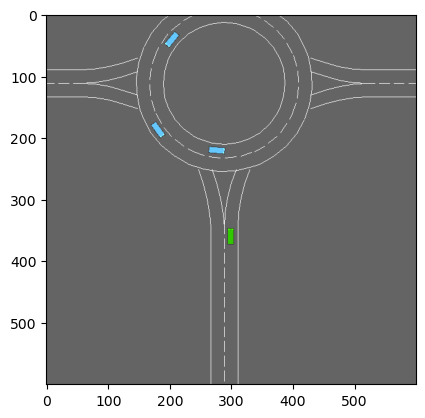

In [15]:
env = gym.make("roundabout-v0", render_mode="rgb_array")
# env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict_sdb3)
env.reset()
plt.imshow(env.render())
plt.show()

In [16]:

model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=10000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [13]:

model.learn(int(6e4))
model.save("highway_dqn/model")

Logging to highway_dqn/DQN_5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.25     |
|    ep_rew_mean      | 5.25     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7        |
|    time_elapsed     | 4        |
|    total_timesteps  | 29       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.12     |
|    ep_rew_mean      | 6.12     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10       |
|    time_elapsed     | 6        |
|    total_timesteps  | 65       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.33     |
|    ep_rew_mean      | 6.33     |
|    exploration_rate | 0.984    |
| time/               |   

In [17]:
# Load and test saved model
model = DQN.load("highway_dqn/model")

In [ ]:
# Tensorboard visualization in another tab
! tensorboard --logdir highway_dqn/


^C


In [18]:
# Performance evaluation of the model

def evaluate_agent(env, agent, n_episodes=10):
    total_rewards = []
    n_successes = 0
    for episode in range(n_episodes):
        print(f"Evaluating episode {episode + 1}/{n_episodes}")
        obs, info = env.reset()
        done = False
        total_reward = 0
        n_step = 0
        while not done:
            n_step+=1
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if n_step > 200:
                done = True
        total_rewards.append(total_reward)
        if not info['crashed']:
            n_successes += 1
    return np.mean(total_rewards), np.std(total_rewards), n_successes / n_episodes

# Evaluate the agent
mean_reward, std_reward, success_rate = evaluate_agent(env, model)
print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Success Rate: {success_rate:.2%}")

Evaluating episode 1/10
Evaluating episode 2/10
Evaluating episode 3/10
Evaluating episode 4/10
Evaluating episode 5/10
Evaluating episode 6/10
Evaluating episode 7/10
Evaluating episode 8/10
Evaluating episode 9/10
Evaluating episode 10/10
Mean Reward: 6.50 ± 2.93
Success Rate: 60.00%


Visualisation

In [4]:
env = gym.make("racetrack-v0", render_mode = "rgb_array")

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

AttributeError: 'NoneType' object has no attribute 'get_image'